# Final Notebook
**Author: Cooper McCombs**

## Overview
For my final project with flatiron, I wanted to find trends in zipcodes to predict the median prices of homes for each zipcode. This allows me to estimate where the housing market is right now and where it will be in a years time based on previous years.

## Business Problem
What I want to achieve in this project is to give an accurate estimation of the real estate market and where it's going. With this information, I would help upcoming investors and homeowners get a understanding of how they should invest their money.

## Data
I got my data from Zillow. It uses median housing prices from the years 2000 to 2022. The reason why the median value of homes is used instead of mean to resist outliers from effecting the data. The dataset I used consists of over 27000 rows of data points and takes information from the first of the month.

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score

import pmdarima as pm
from pmdarima import model_selection
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose, auto_arima
from pmdarima.arima.stationarity import ADFTest

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

C:\Users\coope\anaconda3\envs\time\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


### Importing Data

In [2]:
df = pd.read_csv('Data/zillow_data.csv')
df2 = pd.read_csv('Data/Zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')

### Dropping unneeded columns

In [3]:
df2 = df2.drop(columns = ['RegionType', 'StateName'])

### Function to format data

In [4]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

### Function to make an Auto ARIMA Model

In [5]:
def arima_model(zipcode, dataframe = df):
    '''
    This is an arima model predicting housing prices based on zipcode by taking in a zipcode
    and dataframe and outputting a prediction for the last 12 months, as well as the R-Sqaured,
    Mean Absolute Error, and Root Mean Squared Error scores. The Auto ARIMA Model automatically
    hypertunes the data to get the best version of the trend based on seasonality and trend
    indications in the data.
    '''
    zipcode = dataframe.loc[dataframe['RegionName'] == zipcode]
    melted_df = melt_data(zipcode)
    melted_df.index = pd.to_datetime(melted_df.index)
    train, test = train_test_split(melted_df, test_size = 12, shuffle=False)
    arima = auto_arima(train,
        start_p=1,
        d=None,
        start_1=1,
        trace=True,
        m=12,
        seasonal=True)
    test_preds = pd.Series(arima.predict(n_periods=len(test)), index=test.index)
    print(f"R2 Score: {r2_score(test, test_preds):.4f}")
    print(f"MAE Score: ${mean_absolute_error(test, test_preds):.4f}")
    print(f"RMSE Score: ${mean_squared_error(test, test_preds, squared=False):.4f}")
    actual = train['value'].values[-1]
    trend = test_preds.values[-1]
    ROI = trend - actual
    print(f"ROI: ${(ROI):.4f}")
    fig, ax = plt.subplots(figsize = (8, 6))
    ax.plot(train, label = 'Train')
    ax.plot(test, label = 'Test')
    ax.plot(test_preds, label = 'Test Preds')
    plt.xlabel('Year', fontsize=20)
    plt.ylabel('Median Housing Price', fontsize=20)
    ax.yaxis.set_major_formatter('${x:1.0f}')
    plt.legend()
    return test_preds

## Results

Most zipcodes indicate a positive trend in the current market. My model forcasts one year in advance and accounts for around 87% variance. The zipcode I decided to use for an example is 35173 or Trussville, Alabama and it estimates over a $48000 ROI(return of investment). This graph represents an example of my final model, but the function I wrote allows you to input any zipcode to output a forecasting graph.

Performing stepwise search to minimize aic
 ARIMA(1,2,2)(1,0,1)[12]             : AIC=3757.016, Time=1.45 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=3752.603, Time=0.06 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=3754.439, Time=0.09 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=3754.567, Time=0.12 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=3752.418, Time=0.12 sec
 ARIMA(0,2,0)(2,0,0)[12]             : AIC=3752.957, Time=0.16 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=3753.384, Time=0.45 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=3753.509, Time=0.11 sec
 ARIMA(0,2,0)(2,0,1)[12]             : AIC=3754.977, Time=1.19 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=3754.505, Time=0.41 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=3761.355, Time=0.17 sec
 ARIMA(0,2,0)(1,0,0)[12] intercept   : AIC=3754.317, Time=0.54 sec

Best model:  ARIMA(0,2,0)(1,0,0)[12]          
Total fit time: 5.424 seconds
R2 Score: 0.8670
MAE Score: $5464.6633
RMSE Score: $5794.9132
ROI: $48800.4

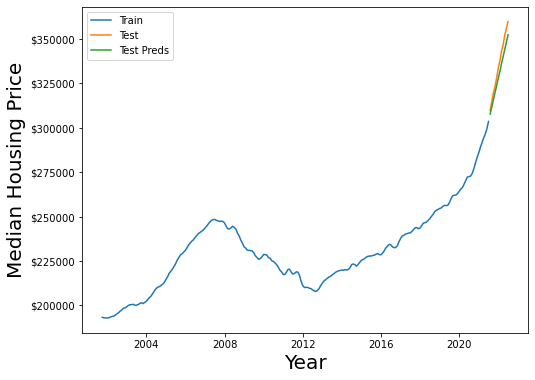

In [6]:
test_preds = arima_model(35173, df2)

## Conclusion
In conclusion, the housing market right now is really good and keeps increasing in prices. This means now is the time to rent homes as you want to set the rate of homes when the value of the house is high in order to have a high rate of rent. This also means that you should not buy right now, but rather sell as I am estimating that in a year or two the housing market will top off and start going back down.

## Future Work
If I had more time to work on this project I would:

- Accommodate for the economy and housing market
- Scrape more housing data from different sources to get a more accurate representation of the whole market
- Increase the accuracy of my model


## For More Information

![Zillow](https://www.zillow.com/research/data/)